In [1]:
%matplotlib inline
%load_ext autoreload

<strong>Dependencies</strong>: MeshPy, PyVTK, trimesh

<strong>Useful links</strong>:
 - TetGen : http://wias-berlin.de/software/tetgen/1.5/doc/manual/manual006.html
 - MeshPy : https://documen.tician.de/meshpy/tri-tet.html#meshpy.tet.MeshInfo.adjacent_elements
 - SRF BluePrint : http://i.cs.hku.hk/~wenping/allhex.pdf
 
 - http://math.stackexchange.com/questions/225246/explanation-about-frames-as-distinct-from-a-co-ordinate-system

## Generate Tetrahedral Mesh

In [4]:
import meshpy
from meshpy.tet import MeshInfo, build
import numpy as np
import trimesh

tri_mesh = trimesh.load_mesh('../data/icosphere.stl')

# Define MeshPy options!
opt = meshpy.tet.Options(switches='pq', edgesout=True, facesout=True, neighout=True)

mesh_info = MeshInfo()
mesh_info.set_points(tri_mesh.vertices)
# Convert face data from np.int64 to int...
faces = [list(map(lambda x: int(x), i)) for i in tri_mesh.faces]
mesh_info.set_facets(faces)
tet_mesh = build(mesh_info, opt, max_volume=10)

# Output tetrahedral mesh
tet_mesh.write_vtk("../data/test.vtk")

## Compute surface curvature

#### Some useful information

 - Internal tetrahedrons have 4 neighbors (one on each face) - the neighbor 4-tuple is the indices of the neighboring tets.

 - The first neighbor of tetrahedron 'i' is oppposite to the first corner of tetrahedron 'i', and so on.

 - An index of -1 indicates there is no neighbor.

In [5]:
surface_faces = []
for i, tet in enumerate(tet_mesh.elements):
    
    neighbors = list(tet_mesh.neighbors[i])
    # Try to get the vertex indices of boundary face.
    # TODO(aidan) This only looks at the first boundary face, consider case where a tet has multiple...
    if -1 in neighbors:
        non_surface_vtx = tet[neighbors.index(-1)]
        tet_cpy = tet.copy()
        tet_cpy.remove(non_surface_vtx)
        surface_faces.append(tet_cpy)


### Compute the normal of each surface triangle

In [110]:
# Compute normal
def compute_normal(face):
    return np.cross(np.array(tet_mesh.points[face[0]]) - np.array(tet_mesh.points[face[1]]),
                    np.array(tet_mesh.points[face[2]]) - np.array(tet_mesh.points[face[1]]))

def compute_avg(face):
    return (np.array(tet_mesh.points[face[0]])
          + np.array(tet_mesh.points[face[1]])
          + np.array(tet_mesh.points[face[2]])) / 3

face_normals = [compute_normal(face) for face in surface_faces]
face_center = [compute_avg(face) for face in surface_faces]

#### Visualize normals

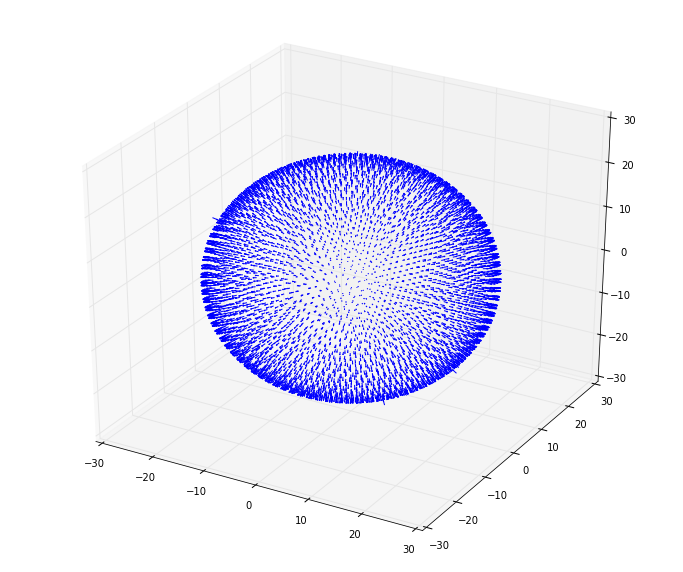

In [111]:
from mpl_toolkits.mplot3d import proj3d
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

for i, f in enumerate(surface_faces):
    ax.quiver(face_center[i][0], face_center[i][1], face_center[i][2], face_normals[i][0], face_normals[i][1], face_normals[i][2])

plt.show()

### Compute the face neighbours of each surface vertices

In [112]:
# Get neighbours
dedup_vertices = set(list(np.concatenate(surface_faces)))
surrounding_faces = {}
for i, v in enumerate(dedup_vertices):
    surrounding_faces[v] = list(filter(lambda f: f[1][0] == v or f[1][1] == v or f[1][2] == v, zip(range(0, len(surface_faces)), surface_faces)))

### Compute the normal of each surface vertices

In [113]:
from numpy import vstack

def get_vertex_norm(face):
    return vstack([face_normals[ind] for ind, f in faces]).mean(axis=0)

v_norms = {}
for i, v in enumerate(dedup_vertices):
    faces = surrounding_faces[v]
    v_norms[v] = get_vertex_norm(faces)

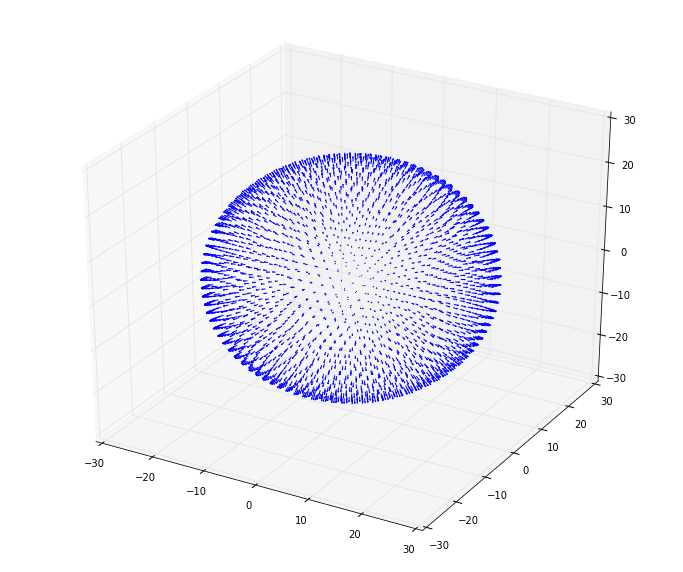

In [114]:
from mpl_toolkits.mplot3d import proj3d
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

for i in dedup_vertices:
    i = int(i)
    ax.quiver(tet_mesh.points[i][0], tet_mesh.points[i][1], tet_mesh.points[i][2], v_norms[i][0], v_norms[i][1], v_norms[i][2])

plt.show()

### Compute curvature

#### Approximate through edge curvature

In [215]:
def givens_rotation(A):
    """Perform QR decomposition of matrix A using Givens rotation."""
    (num_rows, num_cols) = np.shape(A)

    # Initialize orthogonal matrix Q and upper triangular matrix R.
    Q = np.identity(num_rows)
    R = np.copy(A)

    # Iterate over lower triangular matrix.
    (rows, cols) = np.tril_indices(num_rows, -1, num_cols)
    for (row, col) in zip(rows, cols):

        # Compute Givens rotation matrix and
        # zero-out lower triangular matrix entries.
        if R[row, col] != 0:
            (c, s) = _givens_rotation_matrix_entries(R[col, col], R[row, col])

            G = np.identity(num_rows)
            G[[col, row], [col, row]] = c
            G[row, col] = s
            G[col, row] = -s

            R = np.dot(G, R)
            Q = np.dot(Q, G.T)

    return (Q, R)

In [216]:
from numpy import linalg, transpose, dot, cross, multiply
from numpy.linalg import eig, norm


def length(v):
    return linalg.norm(v)

def Matrix(arr_of_3):
    m = np.zeros((3, 3))
    m[0][0] = arr_of_3[0]
    m[1][1] = arr_of_3[1]
    m[2][2] = arr_of_3[2]
    return m

def get_vertices_from_faces(v):
    ring = list(set(np.concatenate([vert for ind, vert in surrounding_faces[v]])))
    ring.remove(v)
    return ring

v = 0
position = np.array(tet_mesh.points[v])
# Vertex normal as a matrix
n0 = np.array(v_norms[v]) / length(v_norms[v])
Nvi = np.zeros((3, 3))
Nvi[0][0] = n0[0]
Nvi[1][1] = n0[1]
Nvi[2][2] = n0[2]

# Unsorted ring
ring = get_vertices_from_faces(v)

# Calculate face weightings, wij
n = len(ring)
wij = np.zeros((n,))
for j in range(n):
    vec0 = tet_mesh.points[int(ring[(j+(n-1))%n])] - position
    vec1 = tet_mesh.points[int(ring[j])] - position
    vec2 = tet_mesh.points[int(ring[(j+1)%n])] - position
    # Assumes closed manifold
    # TODO: handle boundaries
    wij[j] = 0.5 * (length(cross(vec0, vec1)) + length(cross(vec1, vec2)))

# Sum
wijSum = wij.sum()

# Calculate Mvi
I = np.identity(3)
Mvi = np.zeros((3, 3))

curvature = np.zeros((len(ring),))
Mvi = np.zeros((3, 3))

for i, j in enumerate(ring):
    n1 = np.array(v_norms[j])
    vec = tet_mesh.points[int(j)] - np.array(position)
    edgeAsMatrix = Matrix([vec[0], vec[1], vec[2]])
    curvature[i] = dot((n1 - n0), vec) / length(vec)
    Mvi += curvature[i] * edgeAsMatrix * transpose(edgeAsMatrix)

# givens_rotation
"""
for j in range(n):
    vec = tet_mesh.points[int(ring[j])] - position
    edgeAsMatrix = Matrix([vec[0], vec[1], vec[2]])
    Tij = (I - (Nvi * transpose(Nvi))) * edgeAsMatrix
    Tij *= (1 / norm(Tij))
    kij = (transpose(Nvi) * 2 * edgeAsMatrix)[0][0] / (length(vec) ** 2)
    Mvi += multiply(Tij, transpose(Tij)) * ((wij[j] / wijSum) * kij)
"""

# Get eigenvalues and eigenvectors for Mvi
#evals, evecs = eig(Mvi)
# Replace eigenvector matrix with list of Vector3f
#evecs = [Rhino.Geometry.Vector3f(evecs.getEntry(0,i), evecs.getEntry(1,i), evecs.getEntry(2,i)) for i in range(3)]
# Scale eigenvectors by corresponding eigenvalues
#[e.Unitize() for e in evecs]

# sort by absolute value of eigenvalues (norm < min < max)
# sortv: abs curvature, curvature, Vector3f dir
#sortv = zip([abs(i) for i in evals], evals, evecs)
#sortv.sort()
# add min/max principal vectors to list
#tensors.append([sortv[1][-1], sortv[2][-1]])



'\nfor j in range(n):\n    vec = tet_mesh.points[int(ring[j])] - position\n    edgeAsMatrix = Matrix([vec[0], vec[1], vec[2]])\n    Tij = (I - (Nvi * transpose(Nvi))) * edgeAsMatrix\n    Tij *= (1 / norm(Tij))\n    kij = (transpose(Nvi) * 2 * edgeAsMatrix)[0][0] / (length(vec) ** 2)\n    Mvi += multiply(Tij, transpose(Tij)) * ((wij[j] / wijSum) * kij)\n'

In [218]:
givens_rotation(Mvi)

(array([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]]), array([[ 0.86833995,  0.        ,  0.        ],
        [ 0.        ,  0.74287221,  0.        ],
        [ 0.        ,  0.        ,  0.00940802]]))

### Propagate down the mesh